# Financial ML Final Project-Part 1: Sector rotation modeling


Work by: Skander Chouchene, Mohamed Amine Mairech, Oussema Labidi
3rd year EGES - EPT - 2020/2021

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% pip install ciso8601
% pip install fredapi

  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp36-cp36m-linux_x86_64.whl size=28304 sha256=3bb3f078b25e8017c691872b1105cfb77f54377ff8df6da84c85353a516daa1e
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
Successfully built ciso8601


In [3]:
# importing libraries
import pandas as pd
import numpy as np
import ciso8601
import seaborn as sns ; sns.set()
import math
import matplotlib.pyplot as plt
import datetime
from datetime import datetime,timedelta
import statsmodels.api as sm
from patsy import dmatrices

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Predefined Functions

In [4]:
import pandas as pd 
import numpy as np 
from pandas_datareader import data
from fredapi import Fred
fred_api_key = '939a232abc44fc545f5960142a082918'


def sec_rot_load(target_dir = './DATA/'):
    fred = Fred(api_key=fred_api_key)
    series_fed_names = ['CPIAUCSL', 'M1','VIXCLS', 'BAMLC0A0CM',  'BAMLH0A0HYM2', 'T10Y2Y', 'WTISPLC' , 'TB3MS']
    series_names = ['CPI', 'M1', 'VIX', 'IGS', 'HYS', 'TS', 'O' , 'UST3']
    for (sn, sfn) in list(zip(series_names,series_fed_names)):
        print(sn)
        df = fred.get_series_all_releases(sfn)
        df.rename(columns = {'date': 'Date',
                        'value': sfn}, inplace = True)
        df.to_csv(target_dir+'/'+sn+'.csv', index = False)

    etf_names = ['SPY','XTL','XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
    for etf in etf_names:
        df = data.DataReader(etf, 'yahoo', '1990-01-01')
        df['Date']  = df.index
        df.reset_index(drop = True, inplace = True)
        df.to_csv(target_dir+'/'+etf+'.csv', index = False)

    

    pass



    

def sec_rot_ingest(raw_data_dir = './DATA/'):

	var_names = ['CPI', 'M1' ,'VIX','IGS','HYS','TS','O','UST3',
	'SPY','XTL','XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

	raw_data = {}
	for v_nm in var_names:
		raw_data[v_nm]=pd.read_csv(raw_data_dir+v_nm+'.csv', encoding = 'latin-1')


	return raw_data

In [5]:
import pandas as pd 
import numpy as np 


import datetime 


def to_float(s):
	try:
		return float(s)
	except:
		return np.nan

def carry_forward(df, max_date):
    min_date = df['Date'].min()
    # max_date = df['Date'].max()
    all_dates = pd.DataFrame({'Date':    pd.date_range(min_date, max_date) })
    all_dates['Date'] = [str(d)[0:10] for d in  all_dates['Date'] ] 


    df = pd.merge( all_dates, df, how = 'left', on  = 'Date' )
    df = df.apply(lambda x:x.replace(to_replace= np.nan, method = 'ffill'))

    return df


def preprocess(raw_data):

    max_date = datetime.date.today()

    CPI = raw_data['CPI']
    CPI.sort_values(by = 'Date', ascending = True)


    CPI['PriorCPI'] = CPI['CPIAUCSL'].shift(1)
    CPI['CPI_1Mo_Chg'] =  CPI['CPIAUCSL'] - CPI['PriorCPI']
 

    M1 = raw_data['M1']
    M1.sort_values(by = 'Date', ascending = True)


    M1['last_mo_m1'] = M1['M1'].shift(4)
    M1['M1_1Mo_Chg'] = M1['M1'] - M1['last_mo_m1'] 


    SPY = raw_data['SPY']
    SPY.sort_values(by = 'Date', ascending = True)


    SPY['PriorAdjClose'] = SPY['Adj Close'].shift(1)
    SPY['prior_ret_1'] = 10000 * np.log(SPY['Adj Close'] /SPY['PriorAdjClose']  ) 
    SPY['volatility'] =  SPY['prior_ret_1'].rolling(90, min_periods = 5).std()



 


    SPY_Exp = carry_forward(SPY[['Date', 'volatility']], max_date)



    # CPI['Date'] = CPI['DATE']
    CPI_Exp = carry_forward(CPI[['Date', 'CPI_1Mo_Chg']], max_date)

 
    # M1['Date'] = M1['DATE']
    M1_Exp = carry_forward(M1[['Date', 'M1_1Mo_Chg']], max_date)


    VIX = raw_data['VIX']
    # VIX['Date'] = VIX['DATE']
    VIX['VIXCLS'] = [to_float(s) for s in VIX['VIXCLS'] ]    

    VIX_Exp = carry_forward(VIX[['Date', 'VIXCLS']], max_date)
   

    IGS = raw_data['IGS']
    # IGS['Date'] = IGS['DATE']
    IGS['BAMLC0A0CM'] = [to_float(s) for s in IGS['BAMLC0A0CM'] ]    
    IGS_Exp = carry_forward(IGS[['Date', 'BAMLC0A0CM']], max_date)

    HYS = raw_data['HYS']
    # HYS['Date'] = HYS['DATE']
    HYS['BAMLH0A0HYM2'] = [to_float(s) for s in HYS['BAMLH0A0HYM2'] ]
    HYS_Exp = carry_forward(HYS[['Date', 'BAMLH0A0HYM2']], max_date)



    TS = raw_data['TS']
    # TS['Date'] = TS['DATE']
    TS['T10Y2Y'] = [to_float(s) for s in TS['T10Y2Y'] ]
    TS_Exp = carry_forward(TS[['Date', 'T10Y2Y']], max_date)

    O = raw_data['O']
    # O['Date'] = O['DATE']
    O['WTISPLC'] = [to_float(s) for s in O['WTISPLC'] ]

    O_Exp = carry_forward(O[['Date', 'WTISPLC']], max_date)


    UST3 = raw_data['UST3']
    # UST3['Date'] = UST3['DATE']
    UST3['TB3MS'] = [to_float(s) for s in UST3['TB3MS'] ]

    UST3_Exp = carry_forward(UST3[['Date', 'TB3MS']], max_date)



    data_db = pd.merge(SPY_Exp, CPI_Exp, how = 'left', on = 'Date' )

    data_db = pd.merge(data_db, M1_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, VIX_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, IGS_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, HYS_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, TS_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, O_Exp, how = 'left', on = 'Date' )
    data_db = pd.merge(data_db, UST3_Exp, how = 'left', on = 'Date' )


    min_date = pd.Series([SPY['Date'].min(),
	                     CPI['Date'].min(),
	                      M1['Date'].min(),
	                      raw_data['VIX']['Date'].min() , 
	                      raw_data['IGS']['Date'].min(), 
	                      raw_data['HYS']['Date'].min(), 
	                    raw_data['TS']['Date'].min(),  
	                      raw_data['O']['Date'].min(), 
	                    raw_data['UST3']['Date'].min()  
	                     ]).max() 
    max_date = pd.Series([SPY['Date'].max(),
	                     CPI['Date'].max(),
	                      M1['Date'].max(),
	                      raw_data['VIX']['Date'].max() , 
	                      raw_data['IGS']['Date'].max(), 
	                      raw_data['HYS']['Date'].max(), 
	                    raw_data['TS']['Date'].max(),  
	                      raw_data['O']['Date'].max(), 
	                    raw_data['UST3']['Date'].max()  
	                     ]).max() 

    data_db = data_db.loc[(data_db['Date'] >= min_date ) & (data_db['Date']<=max_date), :]
    data_db.reset_index(drop = True, inplace = True)

    return data_db


In [6]:

import pandas as pd
import numpy as np
def bscatter(X,Y,k):
    Xnom, thresh=pd.qcut(X, k, retbins=True)
    tp = pd.DataFrame({'Xnom': Xnom, 'X': X, 'Y':Y})
    GMn  = tp.groupby('Xnom').mean()
    SeMn = tp.groupby('Xnom').std()/ np.sqrt(tp.groupby('Xnom').count())
    Xq = GMn.X
    Yq = GMn.Y
    XSe = SeMn.X
    YSe = SeMn.Y
    return(Xq,XSe,Yq,YSe)

## Data ingestion and preparation 

In [7]:
sec_rot_load(target_dir = '/content/drive/MyDrive/')
raw_data = sec_rot_ingest('/content/drive/MyDrive/')


CPI
M1
VIX
IGS
HYS
TS
O
UST3


### Feature engineering 

In [8]:
data_db = preprocess(raw_data)


In [9]:
data_db.columns.tolist()

['Date',
 'volatility',
 'CPI_1Mo_Chg',
 'M1_1Mo_Chg',
 'VIXCLS',
 'BAMLC0A0CM',
 'BAMLH0A0HYM2',
 'T10Y2Y',
 'WTISPLC',
 'TB3MS']

In [10]:
raw_data.keys()

dict_keys(['CPI', 'M1', 'VIX', 'IGS', 'HYS', 'TS', 'O', 'UST3', 'SPY', 'XTL', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'])

In [11]:
raw_data['XLE'].columns.tolist()

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date']

### Response variables construction 

In [12]:
raw_data_dir = '/content/drive/MyDrive/data/'

In [13]:
def get_target(raw_data, etf_str='XLE', wind = 1):
    data = raw_data[etf_str]
    data.sort_values(by = 'Date', ascending = True)
    data['NextAdjClose'] = data['Adj Close'].shift(-wind)
    data['next_ret_'+str(wind)] = 10000 * np.log(data['NextAdjClose'] /data['Adj Close']  ) 
    return data 
 

In [14]:
tgt_etf = ['XTL', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
sec_target = {}
for t_etf in tgt_etf:
    sec_target[t_etf] = get_target(raw_data, etf_str= t_etf)

In [15]:
sec_target['XLE'].columns.tolist()

['High',
 'Low',
 'Open',
 'Close',
 'Volume',
 'Adj Close',
 'Date',
 'NextAdjClose',
 'next_ret_1']

In [16]:
data_db['Date'] = [int(str(d).replace('-','') ) for d in data_db['Date'] ]  
sec_data = data_db.copy()
for etf in tgt_etf:
    etf_db = sec_target[etf].copy()
    etf_db['Date'] = [int(str(d).replace('-','') ) for d in etf_db['Date'] ]  
    sec_data = pd.merge(sec_data,  etf_db[['Date', 'next_ret_1']], how = 'left', on = ['Date'])
    sec_data.rename(columns = {'next_ret_1': etf+'_next_ret_1' }, inplace = True)
    sec_data.dropna(inplace=True)

## Sector rotation strategy building

In [17]:
sec_data['TradeDate'] = pd.to_datetime(sec_data['Date'], format='%Y%m%d', errors='ignore')
sec_data['TradeDateNext'] = sec_data['TradeDate']  + datetime.timedelta(1)

In [18]:
date_series = sec_data['Date'].loc[sec_data['Date']>=20160101].unique().tolist()

In [19]:
drivers_names = ['volatility',
                 'CPI_1Mo_Chg',
                 'M1_1Mo_Chg',
                 'VIXCLS',
                 'BAMLC0A0CM',
                 'BAMLH0A0HYM2',
                 'T10Y2Y',
                 'WTISPLC',
                 'TB3MS']

In [20]:
response_names = ['XTL_next_ret_1',
                     'XLB_next_ret_1',
                     'XLE_next_ret_1',
                     'XLF_next_ret_1',
                     'XLI_next_ret_1',
                     'XLK_next_ret_1',
                     'XLP_next_ret_1',
                     'XLU_next_ret_1',
                     'XLV_next_ret_1',
                     'XLY_next_ret_1']

In [21]:
sec_data.head()

,Date,volatility,CPI_1Mo_Chg,M1_1Mo_Chg,VIXCLS,BAMLC0A0CM,BAMLH0A0HYM2,T10Y2Y,WTISPLC,TB3MS,XTL_next_ret_1,XLB_next_ret_1,XLE_next_ret_1,XLF_next_ret_1,XLI_next_ret_1,XLK_next_ret_1,XLP_next_ret_1,XLU_next_ret_1,XLV_next_ret_1,XLY_next_ret_1,TradeDate,TradeDateNext
0,20110127,69.316987,0.039,-5.2,16.15,1.59,4.99,2.83,89.42,0.15,0.000000,-157.440203,-43.495574,-176.885969,-196.217899,-233.415561,-96.157210,-134.952200,-181.825285,-331.380541,2011-01-27,2011-01-28
1,20110128,72.100192,0.039,-5.2,20.04,1.60,5.03,2.82,89.42,0.15,-151.082974,165.250455,282.839782,91.885314,113.775568,61.755243,-34.564640,22.092386,22.118960,21.544349,2011-01-28,2011-01-29
2,20110131,72.078852,0.039,37.5,19.53,1.62,5.08,2.84,89.42,0.15,143.294107,264.422284,161.369631,205.195074,139.751162,167.878766,72.452477,100.376211,178.326479,117.649128,2011-01-31,2011-02-01
3,20110131,72.078852,0.039,37.2,19.53,1.62,5.08,2.84,89.42,0.15,143.294107,264.422284,161.369631,205.195074,139.751162,167.878766,72.452477,100.376211,178.326479,117.649128,2011-01-31,2011-02-01
4,20110131,72.078852,0.039,42.0,19.53,1.62,5.08,2.84,89.42,0.15,143.294107,264.422284,161.369631,205.195074,139.751162,167.878766,72.452477,100.376211,178.326479,117.649128,2011-01-31,2011-02-01


## Modeling

In this section, we will use four models to predict next day returns

### Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boosting=GradientBoostingRegressor(max_depth=10, n_estimators=10)

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
random_forest=RandomForestRegressor(max_depth=10, n_estimators=10)

For neural networks, we will use Sci-kit Learn's MLPRegressor as it will provide better computational efficiency than Keras (when training the 4 models, using Keras with the other models took 20 seconds per iteration which will make training take hours, while with sklearn it took 5).

### Shallow Neural Network

In [24]:
from sklearn.neural_network import MLPRegressor
shallow_nn = MLPRegressor(hidden_layer_sizes=(30,), max_iter=10)

### Deep Neutral Network

In [25]:
deep_nn = MLPRegressor(hidden_layer_sizes=(10,20,10), max_iter=10)

###Training all the models

In [26]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Although training day-by-day is more realistic in the context of a sector rotation portfolio, it is computationally costly in terms of time. Therefore we will train every 4 days and predict the next 4 days returns.

In [27]:
import time
from sklearn.metrics import mean_squared_error

perf_trail = []
#Errors lists
OLS_error=[]
Random_forest_error=[]
gradient_boost_error=[]
shollow_nn_error=[]
deep_nn_error=[]



bigy = []
bigy_hat = []
bigy_hat_rf=[]
bigy_hat_gb=[]
bigy_hat_shallow_nn=[]
bigy_hat_deep_nn=[]
bigY_test_list=[]




i=0
outer_test=[]
for d in date_series[::4]:
    #print(d)
    tic = time.clock()
    '''
    Use the prior 3 years of data for training, for computational efficiency 
    '''
    ref_d = int(str(ciso8601.parse_datetime(str(d)) + datetime.timedelta(-3*365))[0:10].replace('-',''))
    train_df = sec_data.loc[(sec_data['Date'] <= d) & (sec_data['Date'] >= ref_d)]
    test_df = sec_data.loc[sec_data['TradeDate'] == train_df['TradeDateNext'].max(),:]

    y = []
    y_hat = []
    y_hat_rf=[]
    y_hat_gb=[]
    y_hat_shallow_nn=[]
    y_hat_deep_nn=[]
    Y_test_list=[]


    f1score=[]

    etf_list = []
    
    
    for tgt_var in response_names:
#         print(tgt_var)
        Y = np.array(train_df[tgt_var].tolist())
        X =  train_df[drivers_names].copy()
        X = sm.add_constant(X)
        #print(Y.shape,X.shape)

        #Fitting the different models to the data
        model = sm.OLS(Y,X).fit() #Linear Regression
        random_forest.fit(X,Y) #Random Forest
        gradient_boosting.fit(X,Y) #Gradient Boosting
        shallow_nn.fit(X,Y) #Shallow Neural Network
        deep_nn.fit(X,Y) #Deep Neural Network


        etf = tgt_var.split('_')[0]
        if test_df.shape[0]>=1:
            tX = test_df[drivers_names].copy()
            tX['const'] = 1 
            tX = tX[['const']+drivers_names]
            Y_test=np.array(test_df[tgt_var].tolist())
            Y_test_list.append(Y_test[0])
            
            y_hat.append(model.predict(tX.iloc[:4,:].values)[:4][0])
            
            y_hat_rf.append(random_forest.predict(tX.iloc[:4,:].values)[0])
            y_hat_gb.append(gradient_boosting.predict(tX.iloc[:4,:].values)[0])
            y_hat_shallow_nn.append(shallow_nn.predict(tX.iloc[:4,:].values)[0])
            y_hat_deep_nn.append(deep_nn.predict(tX.iloc[:4,:].values)[0])
            y.append(test_df[tgt_var].tolist()[0])
            etf_list.append(etf)
    
    if test_df.shape[0]>=1:
      OLS_error.append(mean_squared_error(y_hat,Y_test_list))
      Random_forest_error.append(mean_squared_error(y_hat_rf,Y_test_list))
      gradient_boost_error.append(mean_squared_error(y_hat_gb,Y_test_list))
      shollow_nn_error.append(mean_squared_error(y_hat_shallow_nn,Y_test_list))
      deep_nn_error.append(mean_squared_error(y_hat_deep_nn,Y_test_list))
      bigy .append(y)
      bigy_hat .append(y_hat)
      bigy_hat_rf.append(y_hat_rf)
      bigy_hat_gb.append(y_hat_gb)
      bigy_hat_shallow_nn.append(y_hat_shallow_nn)
      bigy_hat_deep_nn.append(y_hat_deep_nn)
      bigY_test_list.append(Y_test_list)

    
    toc = time.clock()
    print("Iteration took" ,round(toc - tic,1),"s")
    #print("Length of y_hat: ",len(y_hat))
    
    perf_trail.append(pd.DataFrame({'date':d, 'y': y, 'yhat':y_hat, 'yhat_rf':y_hat_rf,'yhat_gb':y_hat_gb, 'yhat_shallow_nn':y_hat_shallow_nn,'yhat_deep_nn':y_hat_deep_nn, 'etf': etf_list}))

print("OLS_error",np.array(OLS_error).mean())            
        


Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.9 s
Iteration took 5.9 s
Iteration took 5.9 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.9 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.7 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.7 s
Iteration took 5.8 s
Iteration took 5.6 s
Iteration took 5.8 s
Iteration took 5.7 s
Iteration took 5.7 s
Iteration took 5.7 s
Iteration took 5.7 s
Iteration too

In [32]:
perf_trail_df = pd.concat(perf_trail)
perf_trail_df.reset_index(drop = True, inplace = True)

In [34]:
perf_trail_df.head()

,date,y,yhat,yhat_rf,yhat_gb,yhat_shallow_nn,yhat_deep_nn,etf
0,20160104,-124.771256,-11.042338,-45.808723,-24.083243,0.459792,-2.775591,XTL
1,20160104,-265.668983,-17.603813,-39.965551,12.992740,-1.150282,-4.835937,XLB
2,20160104,-392.538415,25.354937,-29.801160,19.732654,26.874034,23.880812,XLE
3,20160104,-154.641866,20.270873,-66.962710,-99.195969,1.739717,13.534052,XLF
4,20160104,-155.669009,7.165265,57.687871,177.270447,6.048166,-0.538778,XLI


## Metrics

### Mean Squared Error

In [28]:
#Measuring errors of all the predictions
name=["OLS","Random_forest","gradient_boost","shollow_nn","deep_nn"]
iterate=0
for i in [OLS_error,Random_forest_error,gradient_boost_error,shollow_nn_error,deep_nn_error]:
  print("Mean of errors by standard deviation for "+name[iterate]+": ",np.array(i).mean()/np.array(i).std())
  print("Mean of errors for "+name[iterate]+": \t\t",np.array(i).mean())
  print("======================================================================================\n\n")
  iterate+=1

Mean of errors by standard deviation for OLS:  0.206523324584645
Mean of errors for OLS: 		 28339.8428711129


Mean of errors by standard deviation for Random_forest:  0.3185219300626405
Mean of errors for Random_forest: 		 25000.385038001208


Mean of errors by standard deviation for gradient_boost:  0.3721729680764735
Mean of errors for gradient_boost: 		 23721.21964914131


Mean of errors by standard deviation for shollow_nn:  0.24206067799741002
Mean of errors for shollow_nn: 		 22217.729082812235


Mean of errors by standard deviation for deep_nn:  0.24116981780369942
Mean of errors for deep_nn: 		 21820.389361927024




The Deep Neural Network achieves the lowest mean squared error, although the model errors are quiet comparable. Therefore We need another metric to determine the best one. Let's try the Sharpe ratio

In [29]:
#This block should be run ONLY once
bigY_test_list=np.array(bigY_test_list).T.tolist()
bigy=np.array(bigy).T.tolist()
bigy_hat=np.array(bigy_hat).T.tolist()
bigy_hat_deep_nn=np.array(bigy_hat_deep_nn).T.tolist()
bigy_hat_gb=np.array(bigy_hat_gb).T.tolist()
bigy_hat_rf=np.array(bigy_hat_rf).T.tolist()
bigy_hat_shallow_nn=np.array(bigy_hat_shallow_nn).T.tolist()

### Sharpe Ratio

In [30]:
name01=["OLS","Random_forest","gradient_boost","shollow_nn","deep_nn"]
for i in range(len(bigY_test_list)):
  iterate=0
  print("The real sharpe ratio for "+tgt_etf[i]+": ",np.array(bigY_test_list[i]).mean()/np.array(bigY_test_list[i]).std())
  for j in [bigy_hat,bigy_hat_deep_nn,bigy_hat_gb,bigy_hat_rf,bigy_hat_shallow_nn]:
    print("The sharp ratio for the modeled predictions with "+name01[iterate]+" for "+tgt_etf[i]+": ",np.array(j[i]).mean()/np.array(j[i]).std()-np.array(bigY_test_list[i]).mean()/np.array(bigY_test_list[i]).std())
    iterate+=1
  print("================================================================\n\n")

The real sharpe ratio for XTL:  0.02355624030757951
The sharp ratio for the modeled predictions with OLS for XTL:  0.09819874866514383
The sharp ratio for the modeled predictions with Random_forest for XTL:  0.25890733393199594
The sharp ratio for the modeled predictions with gradient_boost for XTL:  -0.04580797668787032
The sharp ratio for the modeled predictions with shollow_nn for XTL:  -0.07365279513439167
The sharp ratio for the modeled predictions with deep_nn for XTL:  0.2951949777838735


The real sharpe ratio for XLB:  0.00019772923089228013
The sharp ratio for the modeled predictions with OLS for XLB:  0.1978139605483464
The sharp ratio for the modeled predictions with Random_forest for XLB:  0.5038216761231472
The sharp ratio for the modeled predictions with gradient_boost for XLB:  0.09631991614888126
The sharp ratio for the modeled predictions with shollow_nn for XLB:  -0.021743972615670987
The sharp ratio for the modeled predictions with deep_nn for XLB:  0.46853016502321

We can see that Random Forest models and Deep Neural Networks achieve the highest Sharpe Ratios for any sector.

### Real vs Predicted return visualization

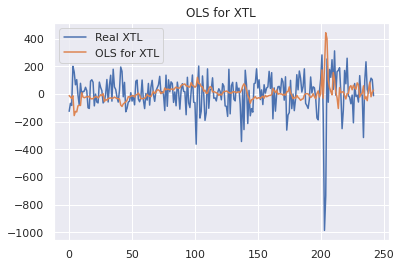

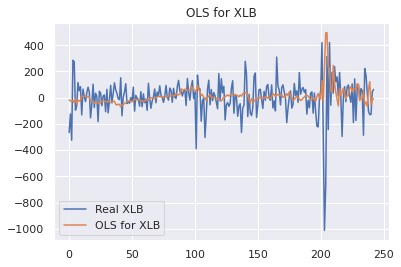

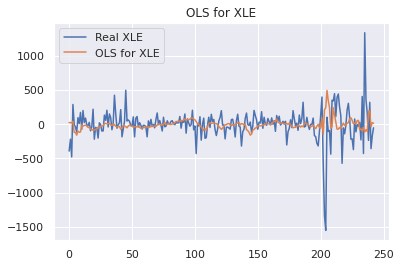

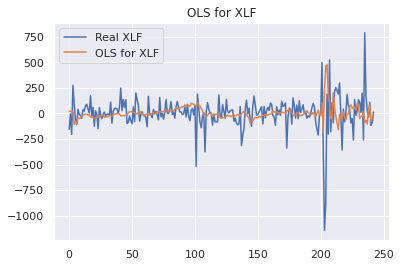

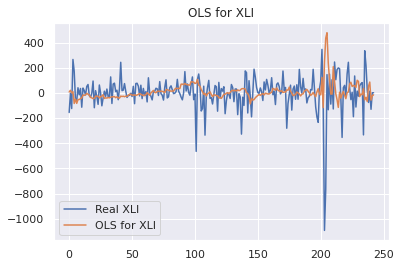

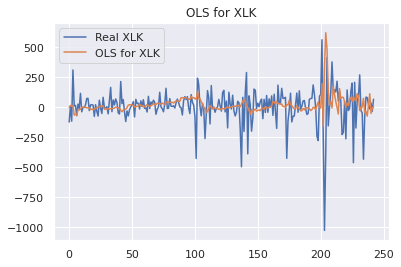

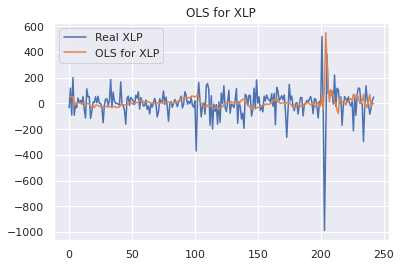

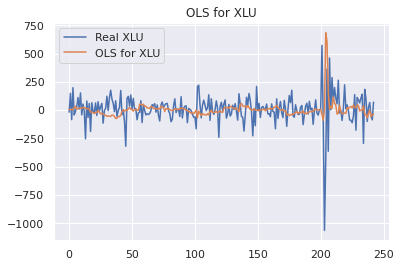

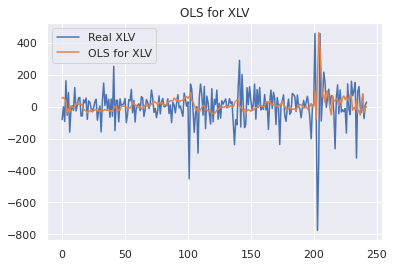

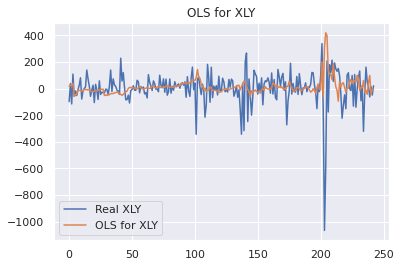

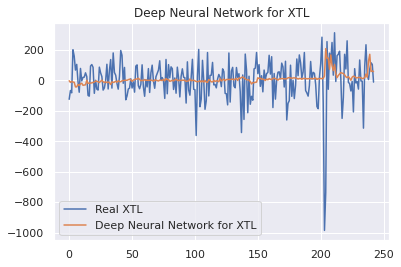

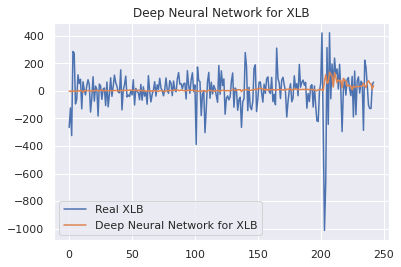

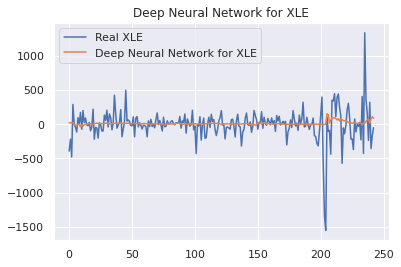

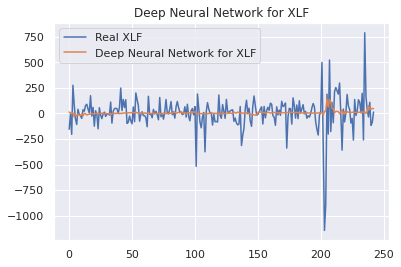

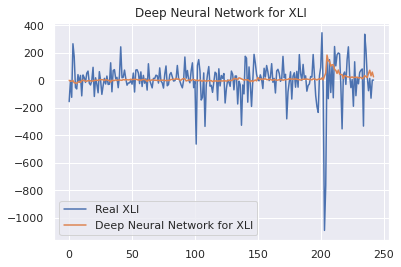

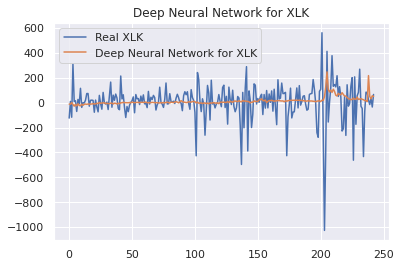

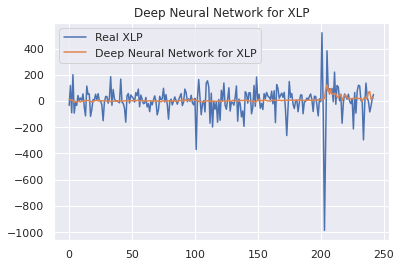

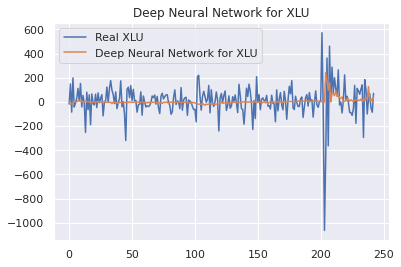

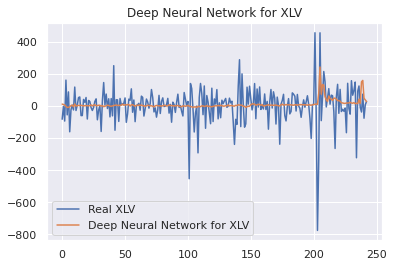

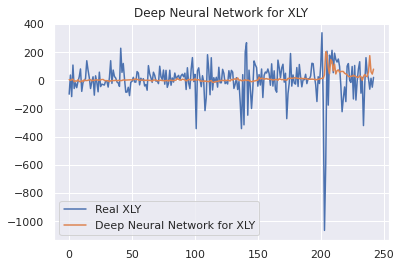

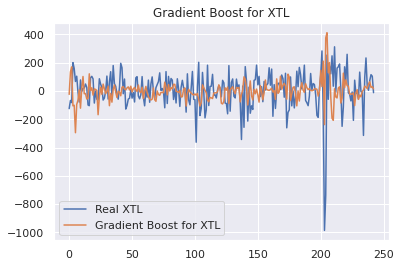

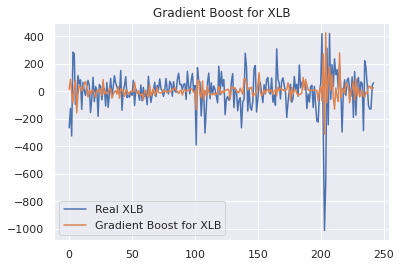

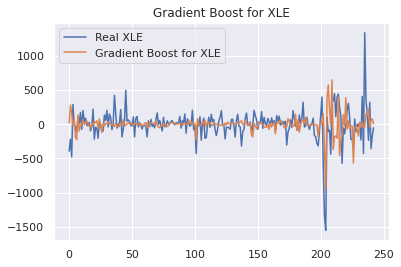

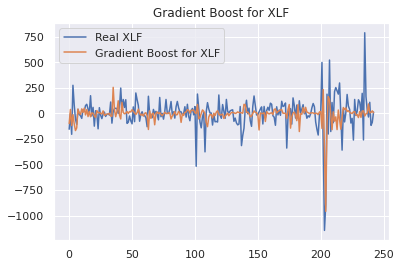

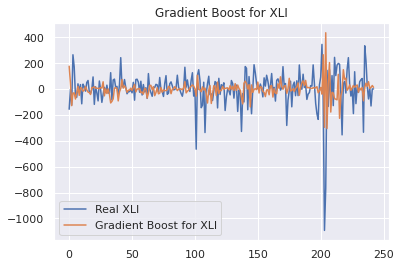

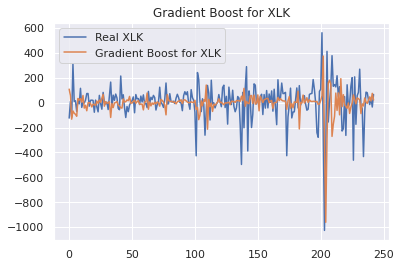

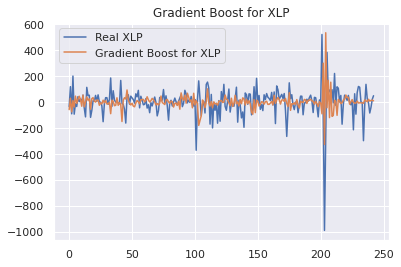

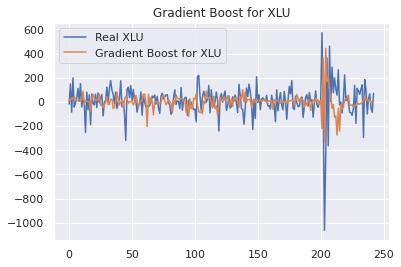

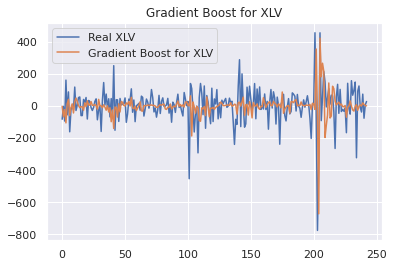

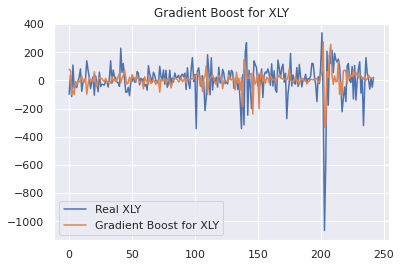

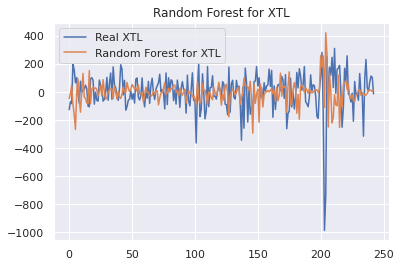

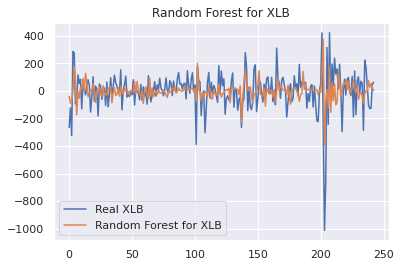

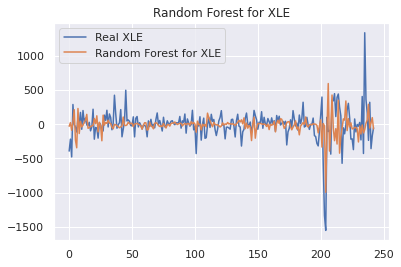

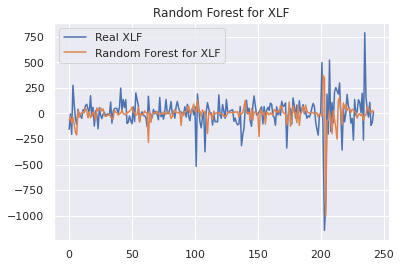

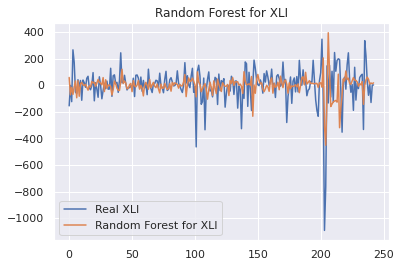

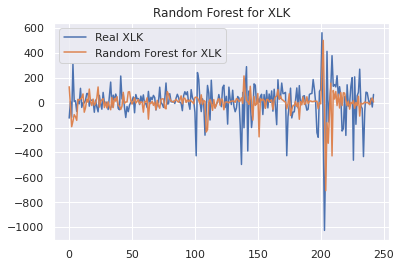

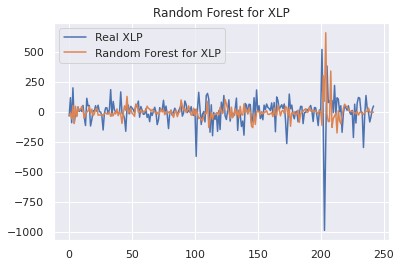

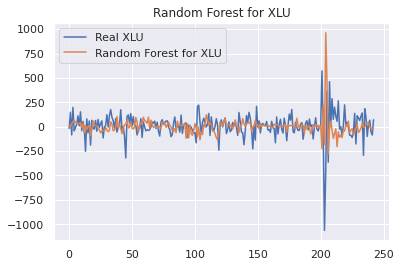

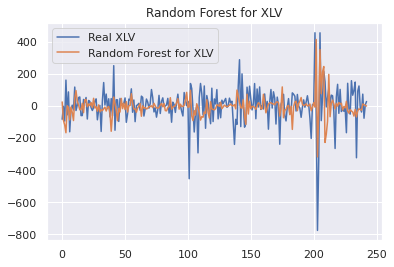

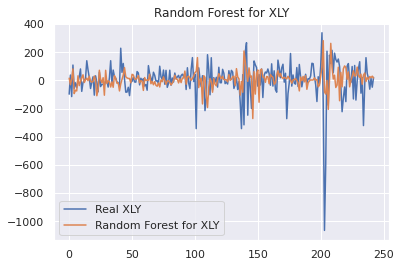

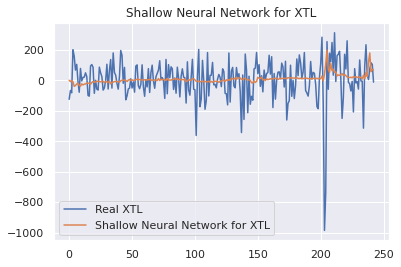

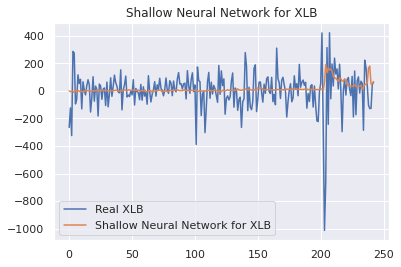

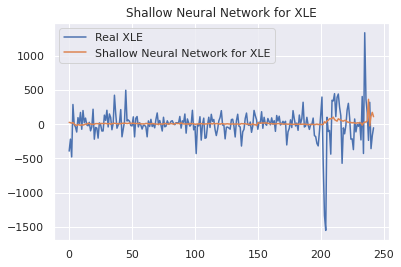

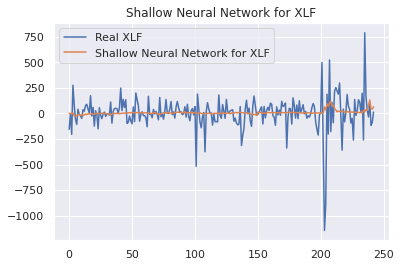

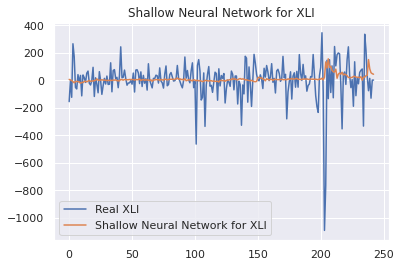

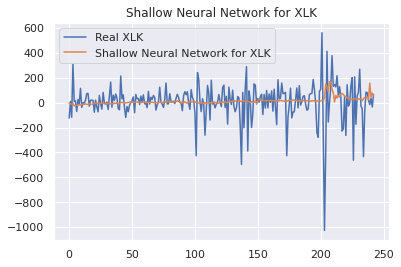

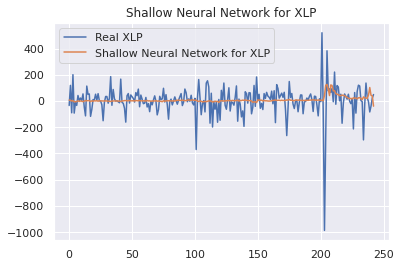

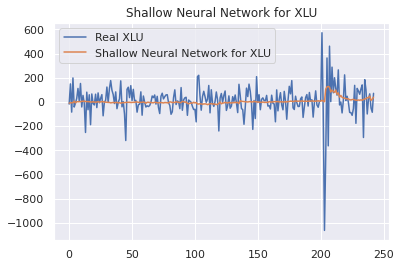

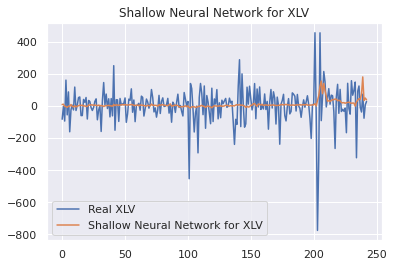

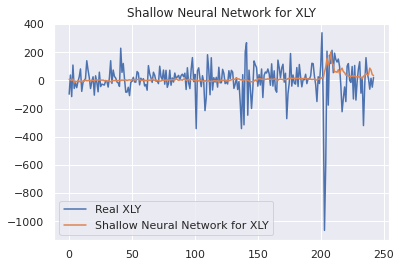

In [31]:
titles=["OLS","Deep Neural Network","Gradient Boost","Random Forest","Shallow Neural Network"]
co=0
for j in [bigy_hat,bigy_hat_deep_nn,bigy_hat_gb,bigy_hat_rf,bigy_hat_shallow_nn]:
  for i in range(10):
    plt.plot(bigY_test_list[i],label="Real "+tgt_etf[i])
    plt.plot(j[i],label=titles[co]+" for "+tgt_etf[i])
    plt.legend()
    plt.title(titles[co]+" for "+tgt_etf[i])
    plt.show()
  co+=1